In [1]:
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sc.settings.set_figure_params(dpi=120)
sns.set_style("dark")

In [3]:
from sklearn.svm import SVR

def filter_cv_vs_mean(S: np.ndarray, N: int, svr_gamma: float=None, plot: bool=True, min_expr_cells: int=2,
                      max_expr_avg: float=20, min_expr_avg: float=0) -> np.ndarray:
    muS = S.mean(1)
    detected_bool = ((S > 0).sum(1) > min_expr_cells) & (muS < max_expr_avg) & (muS > min_expr_avg)
    
    Sf = S[detected_bool, :]
    mu = Sf.mean(1)
    sigma = Sf.std(1, ddof=1)

    cv = sigma / mu
    log_m = np.log2(mu)
    log_cv = np.log2(cv)
    
    if svr_gamma is None:
        svr_gamma = 150. / len(mu)
    
    svr = SVR(gamma=svr_gamma)
    svr.fit(log_m[:, None], log_cv)
    fitted_fun = svr.predict
    ff = fitted_fun(log_m[:, None])
    score = log_cv - ff

    xnew = np.linspace(np.min(log_m), np.max(log_m))
    ynew = svr.predict(xnew[:, None])

    nth_score = np.sort(score)[::-1][N]
    
    if plot:
        plt.scatter(log_m[score > nth_score], log_cv[score > nth_score], s=3, alpha=0.4, c="tab:red")
        plt.scatter(log_m[score <= nth_score], log_cv[score <= nth_score], s=3, alpha=0.4, c="tab:blue")
        mu_linspace = np.linspace(np.min(log_m), np.max(log_m))
        plt.plot(mu_linspace, fitted_fun(mu_linspace[:, None]), c="k")
        plt.xlabel("log2 mean S")
        plt.ylabel("log2 CV S")
    
    cv_mean_score = np.zeros(detected_bool.shape)
    cv_mean_score[~detected_bool] = np.min(score) - 1e-16
    cv_mean_score[detected_bool] = score
    cv_mean_selected = cv_mean_score >= nth_score
    return cv_mean_selected

In [4]:
adata = sc.read_text("H9_RPE_AGED_RawCountMatrix.tsv.gz").T

In [5]:
adata

AnnData object with n_obs × n_vars = 4213 × 33538

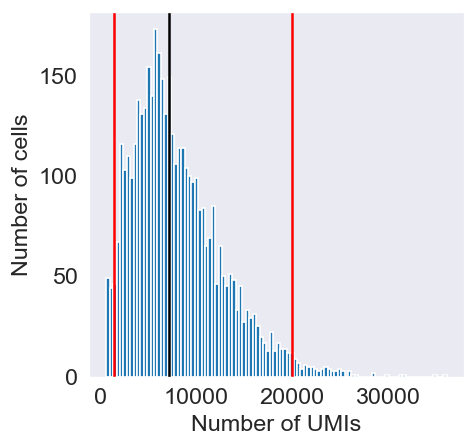

In [6]:
adata.obs['n_counts'] = adata.X.sum(axis=1)
n, bins, *x = plt.hist(adata.obs['n_counts'], bins=100)
plt.xlabel("Number of UMIs")
plt.ylabel("Number of cells")
plt.axvline(1500, c="r")
plt.axvline(np.median(adata.obs['n_counts']), c="black")
plt.axvline(20000, c="r")
plt.show()

In [7]:
sc.pp.filter_cells(adata, min_counts=1500)
sc.pp.filter_cells(adata, max_counts=20000)

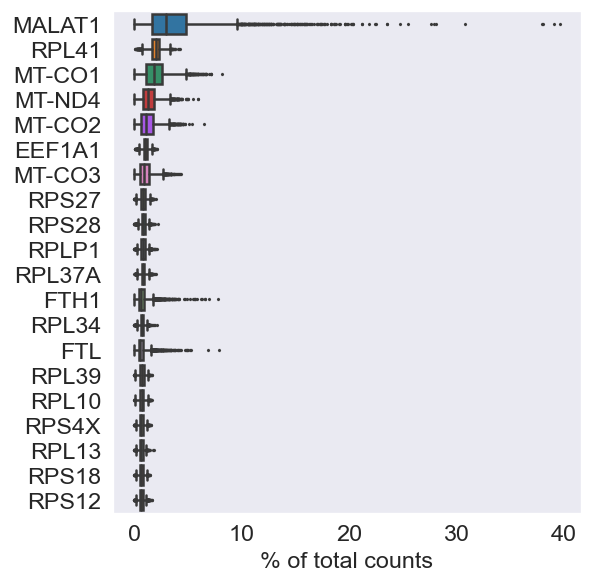

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [9]:
expressed_genes = np.sum(adata.X > 0, 1)
adata.obs['n_genes'] = expressed_genes
len(expressed_genes)

4015

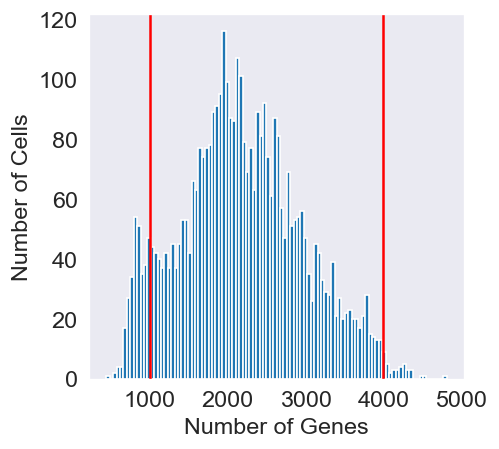

In [10]:
n, bins, *x = plt.hist(expressed_genes, bins=100)
plt.axvline(1000, c="r")
plt.axvline(4000, c="r")
plt.xlabel("Number of Genes")
plt.ylabel("Number of Cells")
plt.show()

In [11]:
adata = adata[adata.obs['n_genes'] > 1000, :].copy()
adata = adata[adata.obs['n_genes'] < 4000, :].copy()

In [12]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
adata.obs['n_counts_filt'] = adata.X.sum(axis=1)

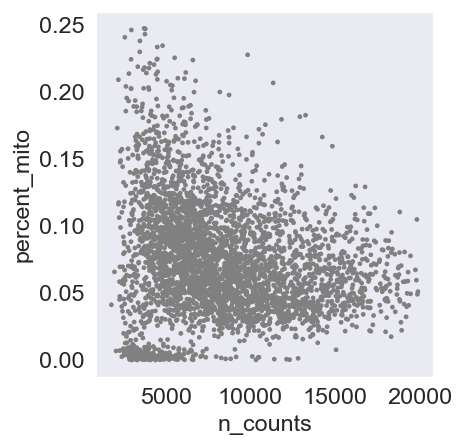

In [13]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')

In [14]:
adata = adata[adata.obs['percent_mito'] < 0.15].copy()
adata = adata[adata.obs['percent_mito'] > 0.02].copy()

In [15]:
adata

AnnData object with n_obs × n_vars = 3216 × 33538
    obs: 'n_counts', 'n_genes', 'percent_mito', 'n_counts_filt'

In [16]:
adata_raw = adata.copy()

In [17]:
S_genes_hum = ["MCM5", "PCNA", "TYMS", "FEN1", "MCM2", "MCM4", "RRM1", "UNG", "GINS2", 
            "MCM6", "CDCA7", "DTL", "PRIM1", "UHRF1", "CENPU", "HELLS", "RFC2", 
            "RPA2", "NASP", "RAD51AP1", "GMNN", "WDR76", "SLBP", "CCNE2", "UBR7", 
            "POLD3", "MSH2", "ATAD2", "RAD51", "RRM2", "CDC45", "CDC6", "EXO1", "TIPIN", 
            "DSCC1", "BLM", "CASP8AP2", "USP1", "CLSPN", "POLA1", "CHAF1B", "BRIP1", "E2F8"]
G2M_genes_hum = ["HMGB2", "CDK1", "NUSAP1", "UBE2C", "BIRC5", "TPX2", "TOP2A", "NDC80",
             "CKS2", "NUF2", "CKS1B", "MKI67", "TMPO", "CENPF", "TACC3", "PIMREG", 
             "SMC4", "CCNB2", "CKAP2L", "CKAP2", "AURKB", "BUB1", "KIF11", "ANP32E", 
             "TUBB4B", "GTSE1", "KIF20B", "HJURP", "CDCA3", "JPT1", "CDC20", "TTK",
             "CDC25C", "KIF2C", "RANGAP1", "NCAPD2", "DLGAP5", "CDCA2", "CDCA8", "ECT2", 
             "KIF23", "HMMR", "AURKA", "PSRC1", "ANLN", "LBR", "CKAP5", "CENPE", 
             "CTCF", "NEK2", "G2E3", "GAS2L3", "CBX5", "CENPA"]
sc.tl.score_genes_cell_cycle(adata, s_genes=S_genes_hum, g2m_genes=G2M_genes_hum)

In [18]:
sc.pp.filter_genes(adata, min_cells=20)

In [19]:
adata

AnnData object with n_obs × n_vars = 3216 × 14495
    obs: 'n_counts', 'n_genes', 'percent_mito', 'n_counts_filt', 'S_score', 'G2M_score', 'phase'
    var: 'n_cells'

In [20]:
sc.pp.normalize_total(adata)

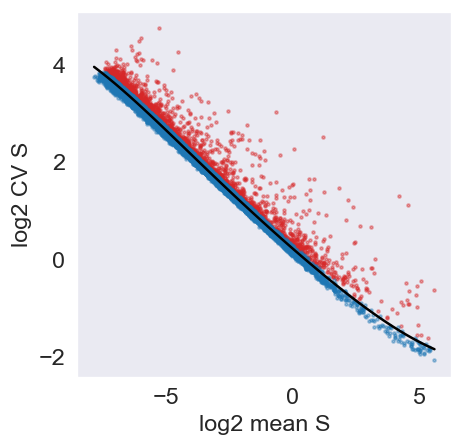

In [21]:
cv_vs_mean_keep = filter_cv_vs_mean(adata.X.T, N=2000, max_expr_avg=50)

In [22]:
sc.pp.log1p(adata)

In [23]:
adata = adata[:, cv_vs_mean_keep].copy()

In [24]:
sc.pp.regress_out(adata, "percent_mito")
sc.pp.regress_out(adata, "n_counts")

... storing 'phase' as categorical


In [25]:
sc.pp.scale(adata, max_value=10)

In [26]:
sc.tl.pca(adata, svd_solver='arpack')

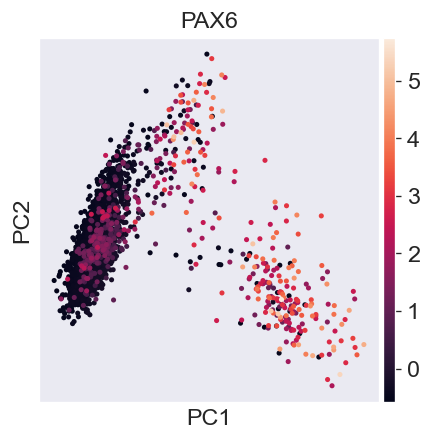

In [27]:
sc.pl.pca(adata, color='PAX6')

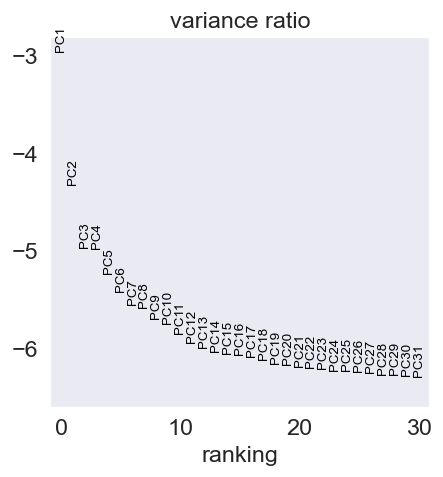

In [28]:
sc.pl.pca_variance_ratio(adata, log=True)

In [29]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=15)

In [30]:
sc.tl.umap(adata, alpha=0.3, min_dist=.5)

In [31]:
sc.tl.louvain(adata, resolution=1.25)

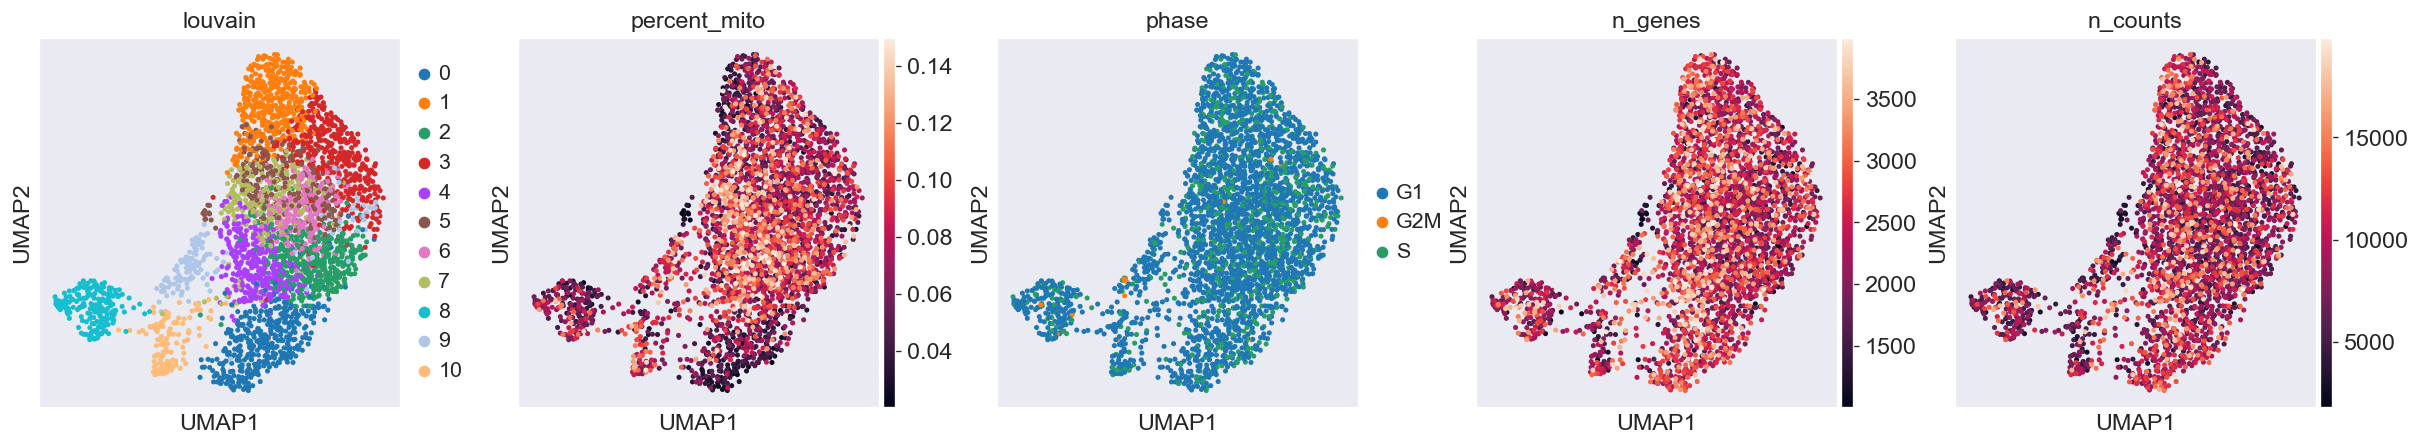

In [32]:
sc.pl.umap(adata, use_raw=False, color=["louvain", "percent_mito", "phase", "n_genes", "n_counts"], ncols=5)

In [33]:
adata.raw = adata_raw

In [34]:
adata_raw_norm = adata_raw.copy()

In [35]:
adata_raw_norm

AnnData object with n_obs × n_vars = 3216 × 33538
    obs: 'n_counts', 'n_genes', 'percent_mito', 'n_counts_filt'

In [36]:
sc.pp.normalize_total(adata_raw_norm)
sc.pp.log1p(adata_raw_norm)

In [37]:
adata_raw_norm.obsm["X_umap"] = adata.obsm["X_umap"]
adata_raw_norm.obs["phase"] = [i for i in adata.obs["phase"]]
adata_raw_norm.obs["louvain"] = [i for i in adata.obs["louvain"]]

... storing 'phase' as categorical
... storing 'louvain' as categorical


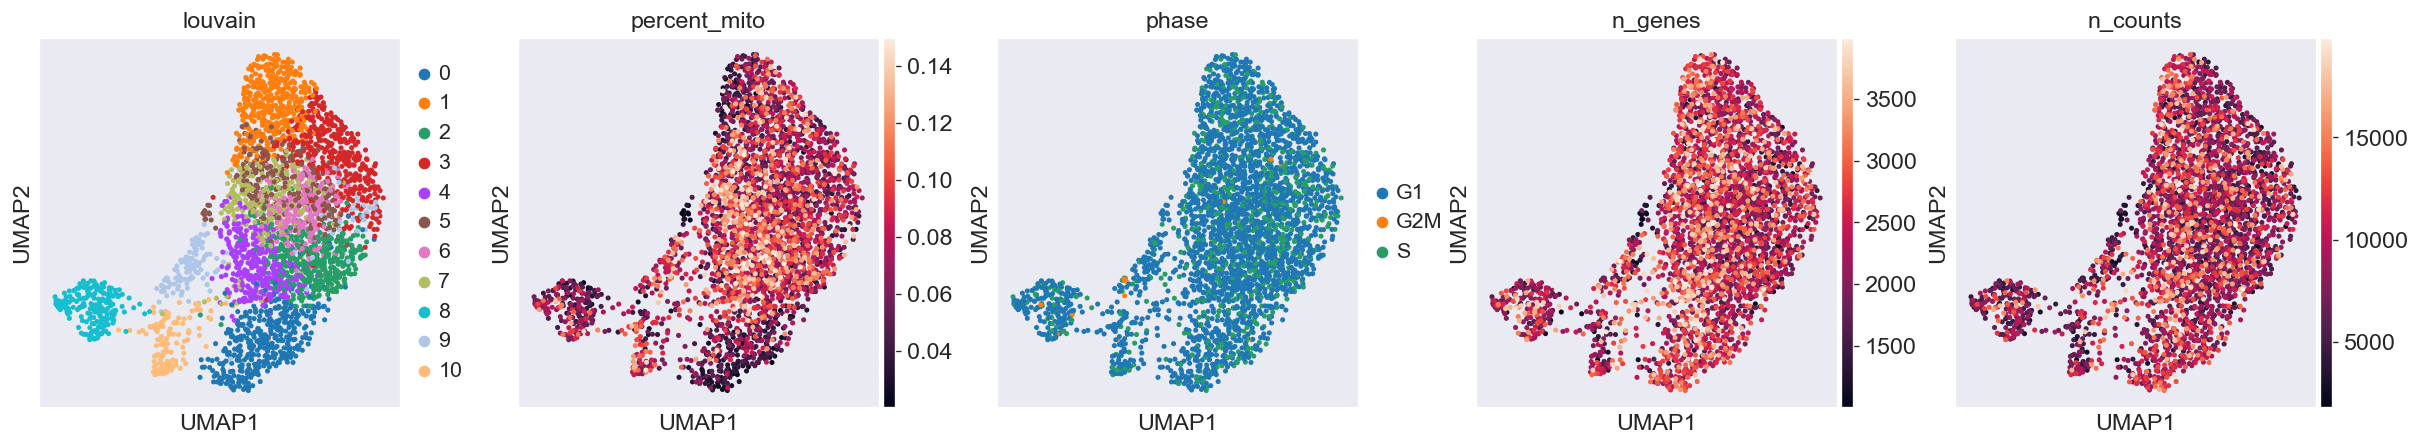

In [38]:
sc.pl.umap(adata_raw_norm, use_raw=False, color=["louvain", "percent_mito", "phase", "n_genes", "n_counts"], ncols=5)

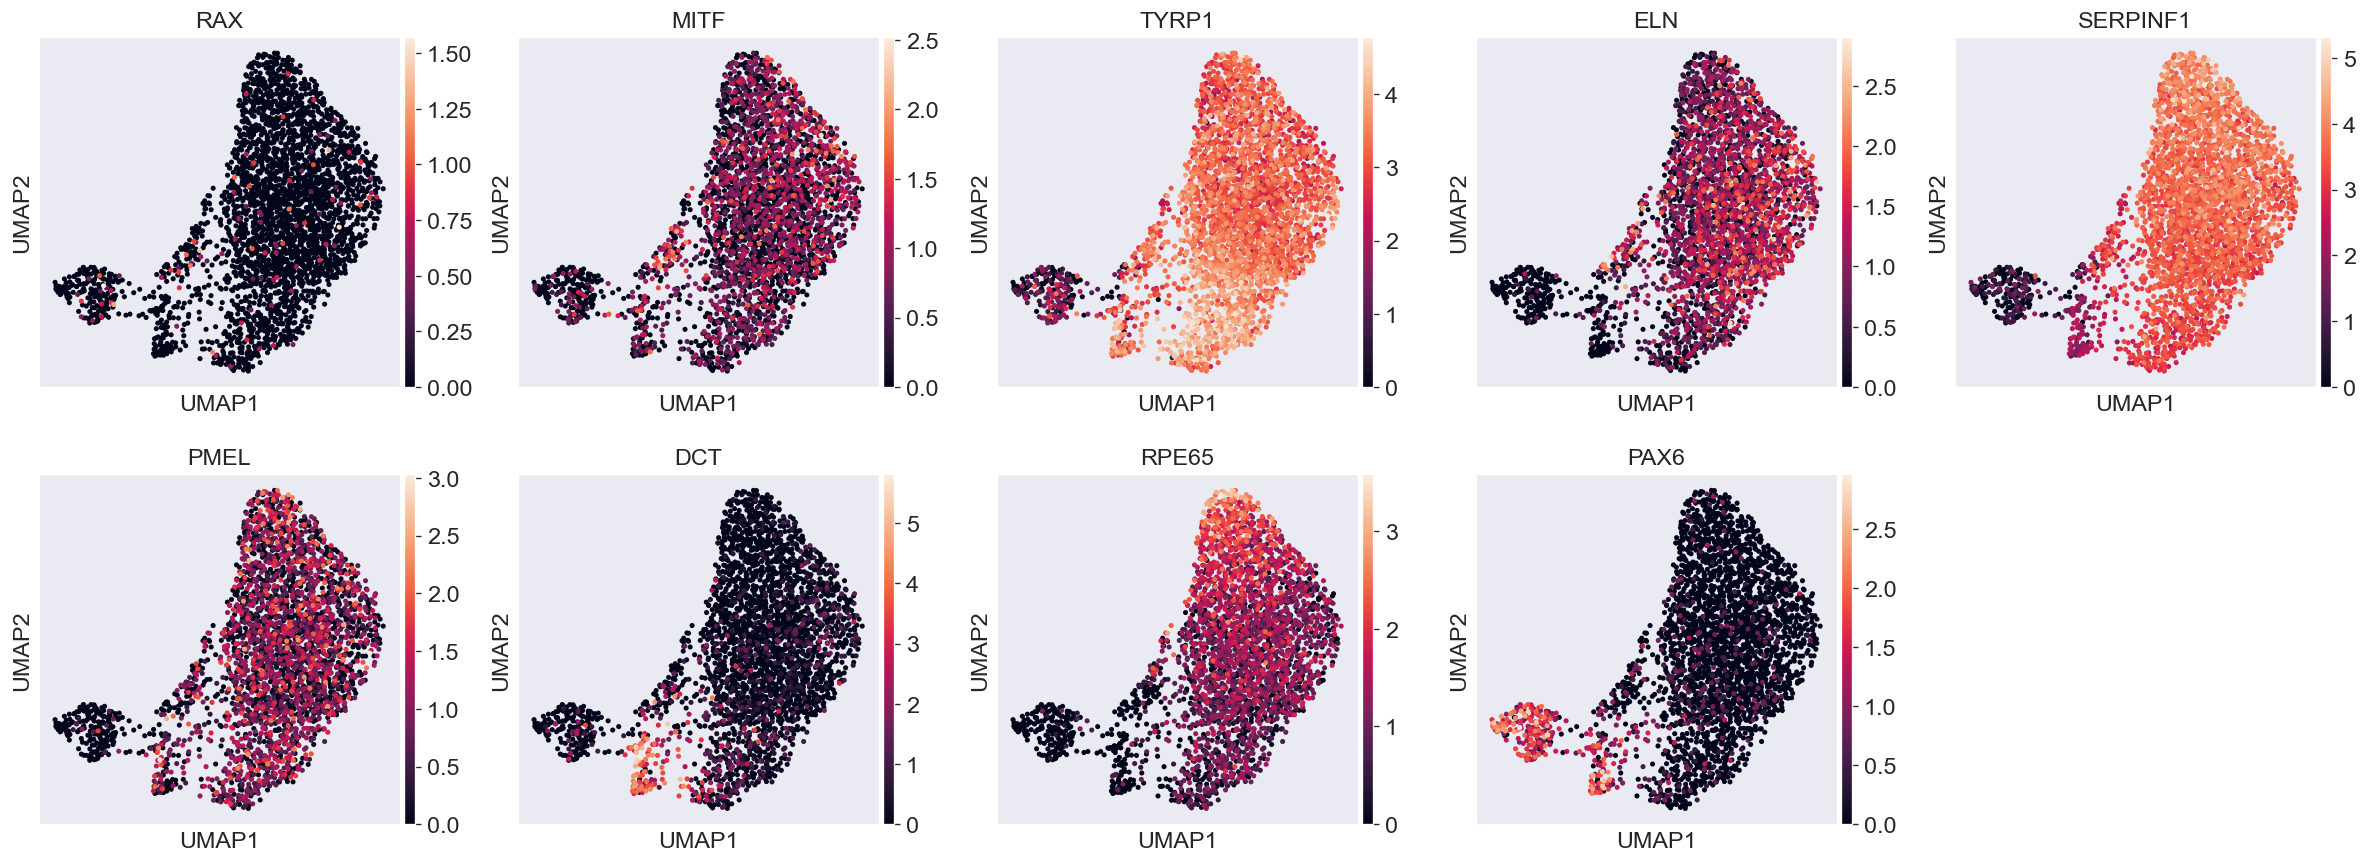

In [39]:
sc.pl.umap(adata_raw_norm, use_raw=False, color=["RAX", "MITF", "TYRP1", "ELN", "SERPINF1", "PMEL",
                                                 "DCT", "RPE65", "PAX6"], ncols=5)

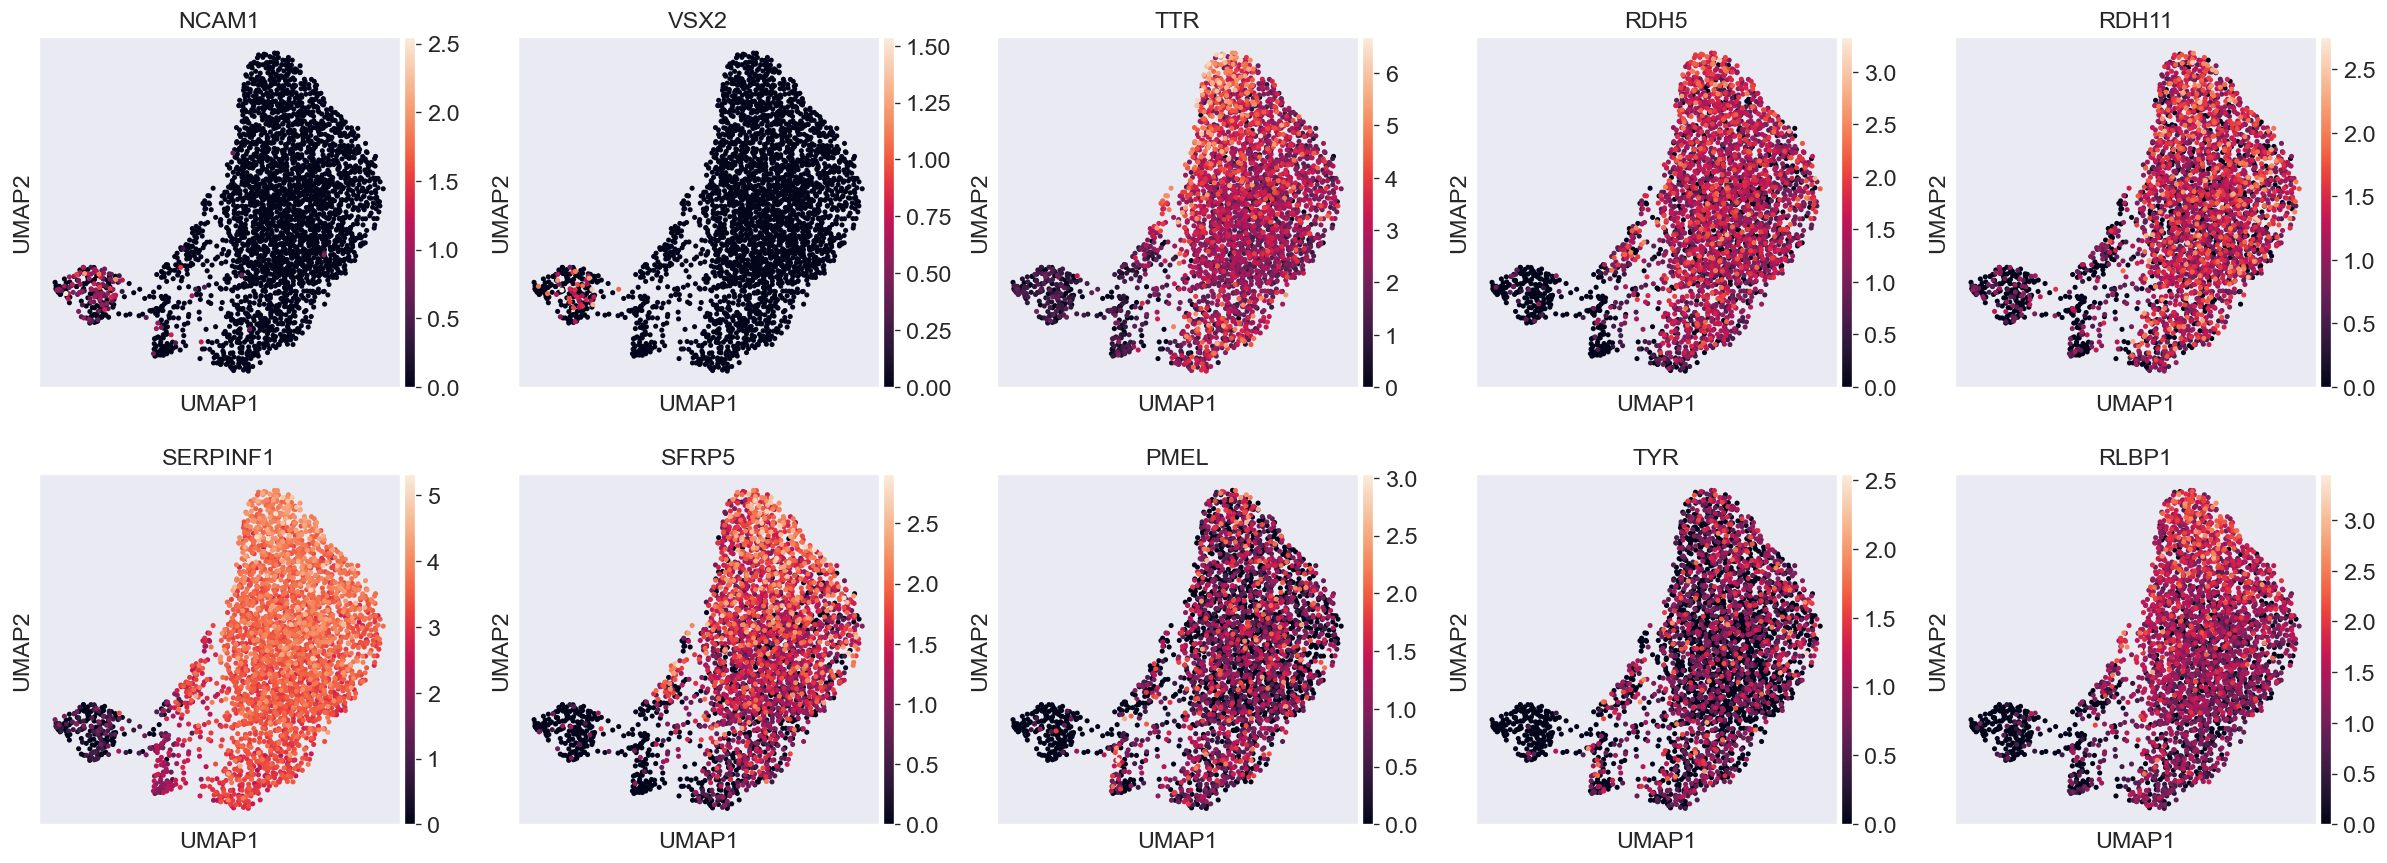

In [40]:
sc.pl.umap(adata_raw_norm, use_raw=False, color=["NCAM1", "VSX2", "TTR", "RDH5",
                                                "RDH11", "SERPINF1", "SFRP5", "PMEL", "TYR", "RLBP1"], ncols=5)

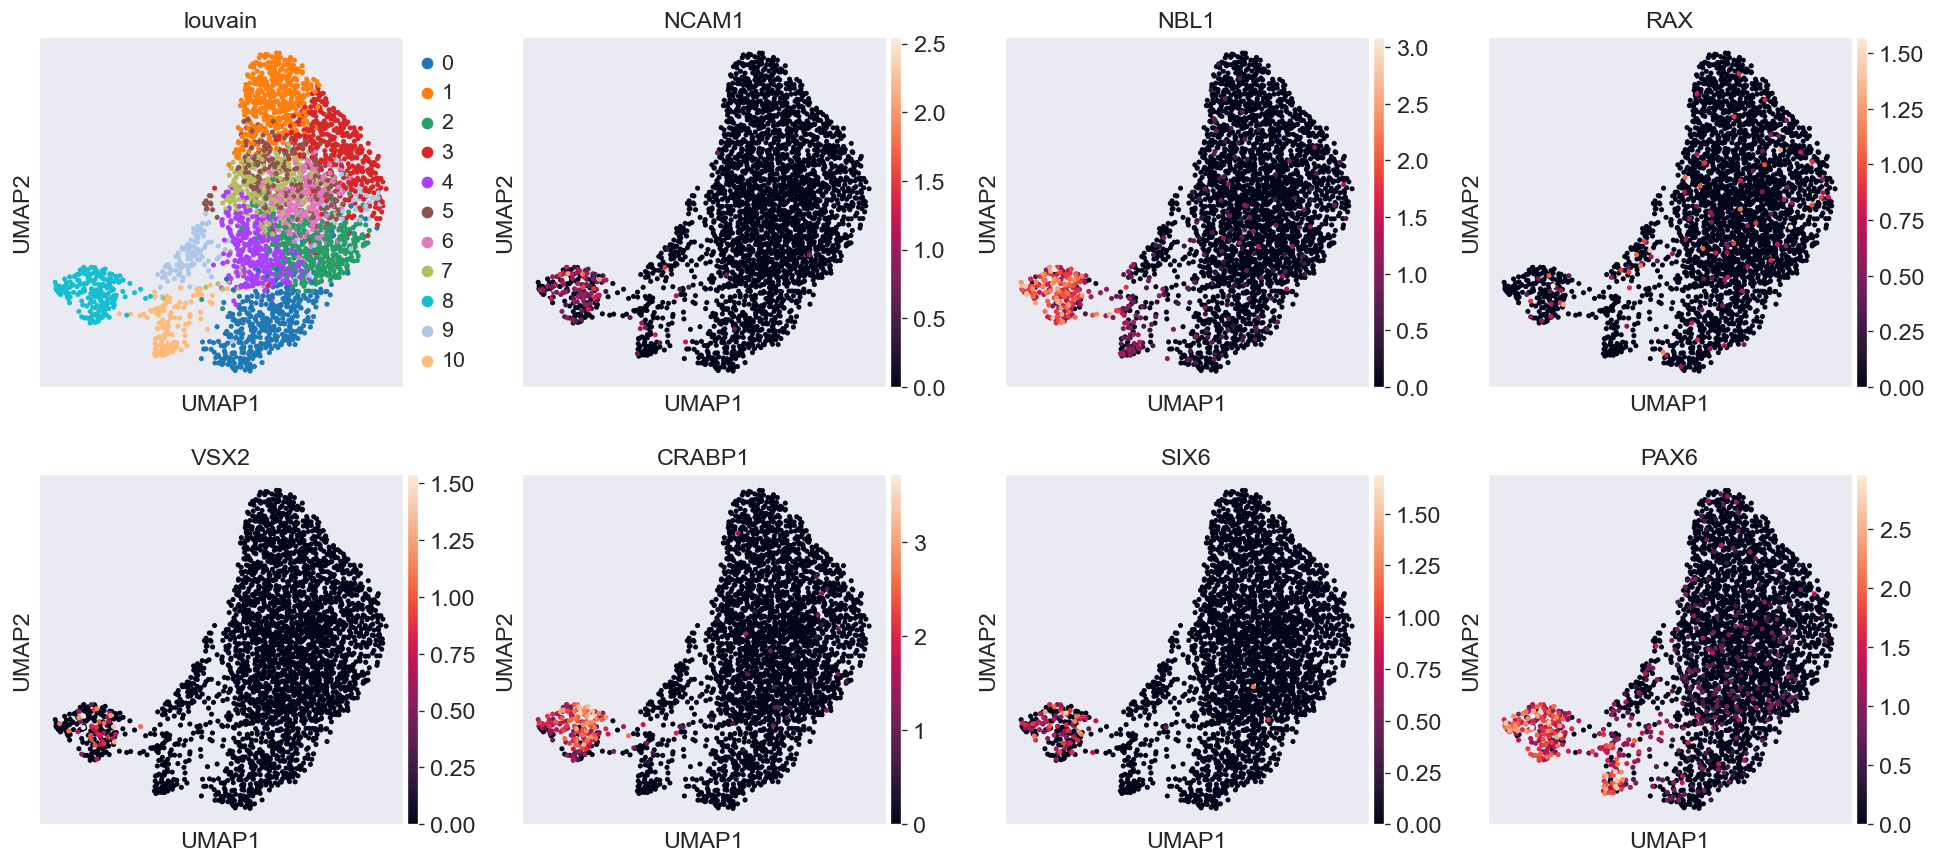

In [41]:
sc.pl.umap(adata_raw_norm, use_raw=False, color=["louvain", "NCAM1", "NBL1", "RAX", "VSX2",
                                                "CRABP1", "SIX6", "PAX6"], ncols=4)

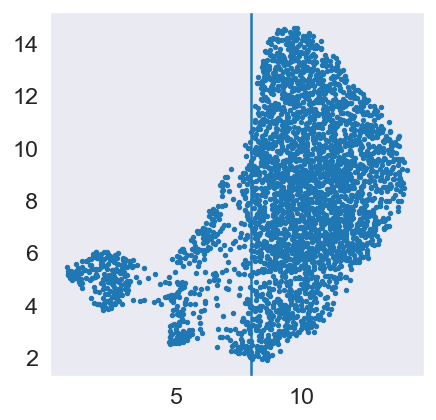

In [42]:
em = adata_raw_norm.obsm["X_umap"]
plt.scatter(em[:, 0], em[:, 1], s=5)
plt.axvline(8)

In [43]:
nl = []
for x, y, l in zip(em[:, 0], em[:, 1], adata_raw_norm.obs["louvain"]):
    if x>8 and l=="9":
        nl.append('11')
    else:
        nl.append(l)
adata_raw_norm.obs["louvain"] = nl

In [44]:
l2ct = {'0':"LateRPE", '1':"LateRPE", '2':"LateRPE", 
        '3':"LateRPE", '4':"LateRPE", '5':"LateRPE", '6':"LateRPE", '7':"LateRPE", '8':"RetProg", '9':"LateRPE",
       "10":"EMT-RPE", "11":"LateRPE"}
adata_raw_norm.obs["cell_type"] = [l2ct[i] for i in adata_raw_norm.obs["louvain"]]

... storing 'louvain' as categorical
... storing 'cell_type' as categorical


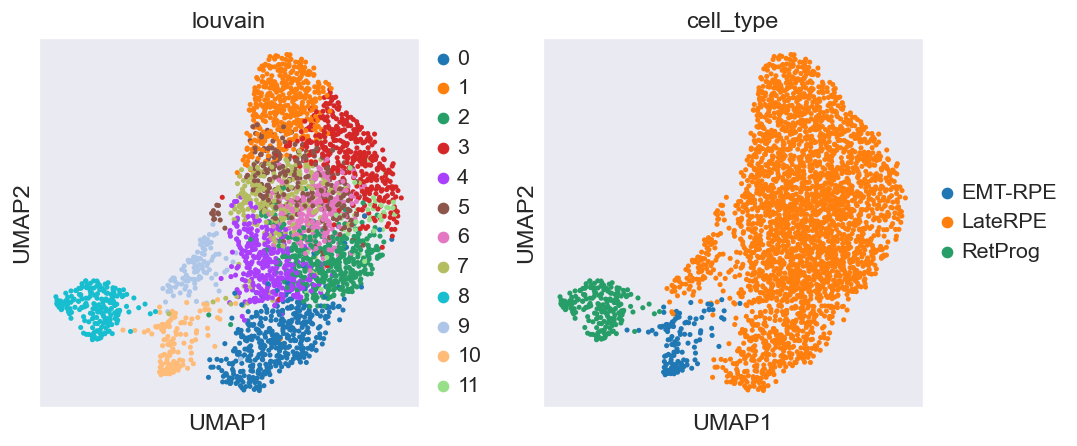

In [45]:
sc.pl.umap(adata_raw_norm, use_raw=False, color=["louvain", "cell_type"], ncols=4)

In [46]:
sc.tl.rank_genes_groups(adata_raw_norm, 'cell_type', method='wilcoxon', use_raw=True)

In [47]:
pd.DataFrame(adata_raw_norm.uns['rank_genes_groups']['names']).head(10)

EMT-RPE   LateRPE   RetProg
0    DAPL1  SERPINF1        CP
1   TMSB4X      CST3    TMSB4X
2      DCT     BEST1     NEAT1
3     FTH1  SERPINE3  NDUFA4L2
4    GPNMB      FRZB   TSC22D1
5     GJA1     DUSP4       VIM
6   IGFBP7     SMOC2      NBL1
7     PAX6    RNASE1     DAPL1
8  HSD17B2      AQP1     PODXL
9   IGFBP4      CTSD    IGFBP2

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


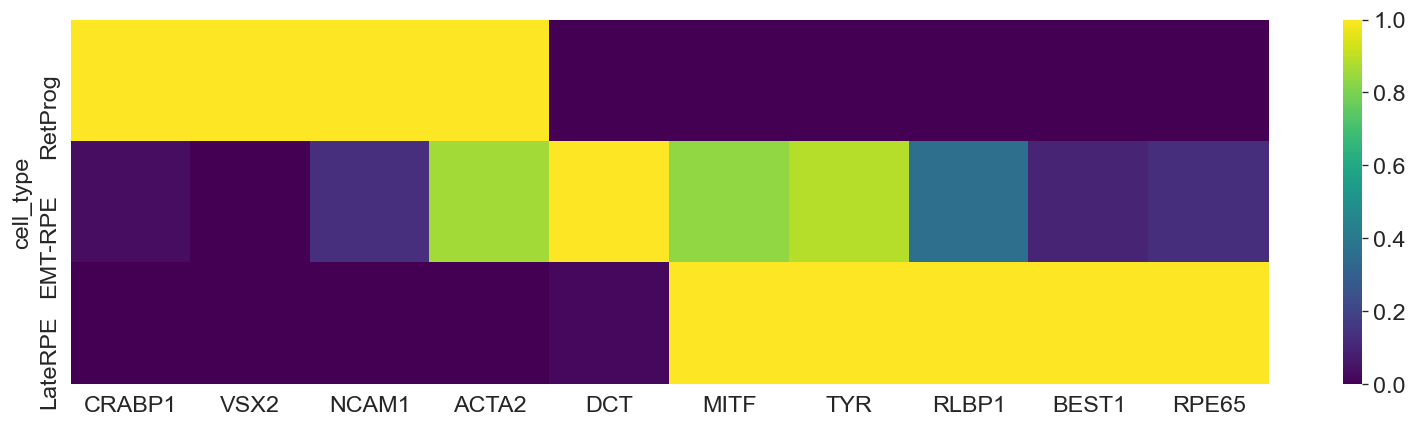

In [48]:
genes = ["CRABP1", "VSX2", "NCAM1", "ACTA2",
         "DCT", "MITF", "TYR", 
        "RLBP1", "BEST1", "RPE65"]
X = pd.DataFrame(adata_raw_norm[:, genes].X.toarray())
X.index = adata_raw_norm.obs["cell_type"]
X.columns = genes
X = X.groupby(X.index).mean()

X = X.loc[['RetProg', 'EMT-RPE', 'LateRPE']]

plt.figure(None, (16, 4))
sns.heatmap((X - X.min()) / (X.max() - X.min()), cmap='viridis')
plt.show()

In [49]:
young = sc.read_h5ad("H9_RPE_YOUNG_Annotated_ProcessedRaw.h5ad")
aged = sc.read_h5ad("H9_RPE_AGED_Annotated_ProcessedRaw.h5ad")

In [50]:
young.obs["Day"] = "D90"
aged.obs["Day"] = "D432"
both = young.concatenate(aged)
both.obs["FullName"] = [i+"-"+j for i,j in zip(both.obs["cell_type"], both.obs["Day"])]

In [51]:
sc.pp.normalize_total(both)
sc.pp.log1p(both)

... storing 'cell_type' as categorical
... storing 'Day' as categorical
... storing 'FullName' as categorical


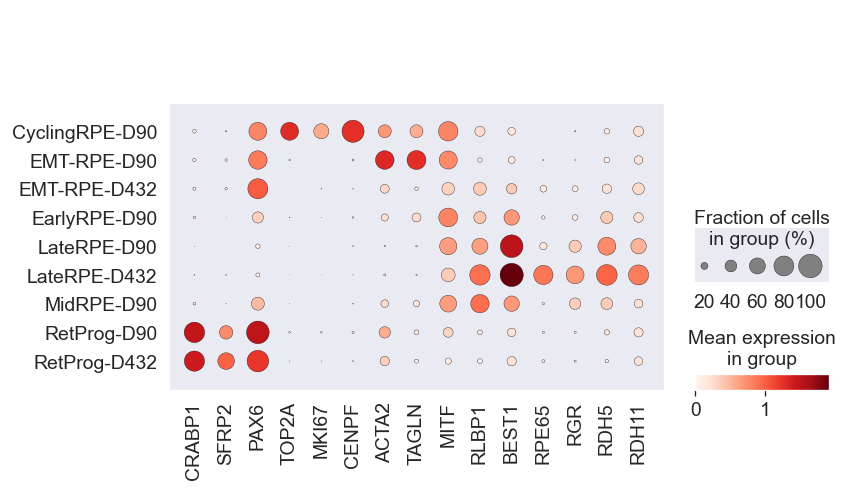

In [52]:
sc.pl.dotplot(both, var_names=["CRABP1", "SFRP2", "PAX6", "TOP2A", "MKI67", "CENPF",
                              "ACTA2", "TAGLN", "MITF", "RLBP1", "BEST1", "RPE65", "RGR", "RDH5", "RDH11"], 
              groupby="FullName")